In [2]:
# Imports

import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.preprocessing import StandardScaler
from scipy.optimize import least_squares
from dask import delayed, compute
from dask.distributed import Client
from tqdm import tqdm
import tensorflow as tf
import hls4ml

# %matplotlib inline
output_scaler = StandardScaler()
print(tf.config.list_physical_devices('GPU'))

np.random.seed(0)
tf.random.set_seed(0)

# Environment Variables: 

YES = 1
NO = 0

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Loading HDF5 data...
[Saved] Input images to test_input.txt (5 images, each as one line)


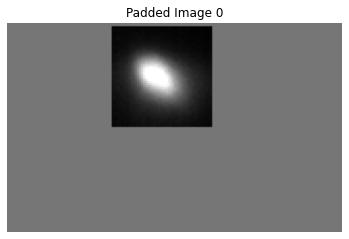

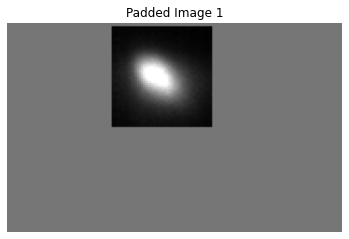

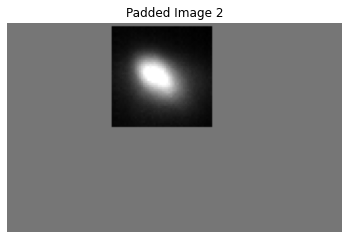

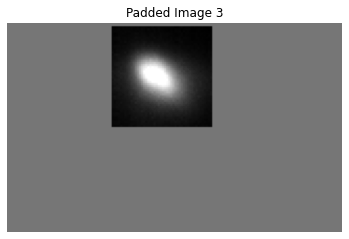

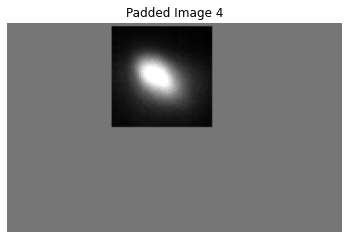

[Final Shape] Padded Images: (5, 100, 160)


In [16]:
import numpy as np
import h5py
from PIL import Image
import matplotlib.pyplot as plt

# Read H5 Data File
DATA_DIR = ''  # Change to your DATA PATH
RHEED_DATA_FILE = DATA_DIR + 'RHEED_4848_test6.h5'
spot = 'spot_2'
h5 = h5py.File(RHEED_DATA_FILE, 'r')

# Load raw data
raw_data = []
for growth in h5.keys():
    raw_data.extend(h5[growth][spot])
raw_data = np.array(raw_data).astype(np.float32)

# Take the first 5 images
NUM_IMAGES = 1
raw_data = raw_data[:NUM_IMAGES, :, :]

# Define padding parameters
CROP_START_X = 50
CROP_START_Y = 2
IMAGE_HEIGHT = 100
IMAGE_WIDTH = 160
PAD_VAL = 128

def pad_images(images, pad_value=0, start_x=0, start_y=0, target_width=128, target_height=32):
    num_images, img_height, img_width = images.shape
    padded_images = np.full((num_images, target_height, target_width), pad_value, dtype=images.dtype)
    for i in range(num_images):
        end_x = min(start_x + img_width, target_width)
        end_y = min(start_y + img_height, target_height)
        padded_images[i, start_y:end_y, start_x:end_x] = images[i, :end_y - start_y, :end_x - start_x]
    return padded_images

# Convert raw data to uint8
uint8_data = raw_data.astype(np.uint8)

# Pad the images
padded_images = pad_images(uint8_data, pad_value=PAD_VAL, start_x=CROP_START_X, start_y=CROP_START_Y, 
                           target_width=IMAGE_WIDTH, target_height=IMAGE_HEIGHT)

# Save all images to a text file in hexadecimal format
output_file = 'padded_images_hex.txt'
with open(output_file, 'w') as f:
    for i in range(NUM_IMAGES):
        flattened = padded_images[i].flatten()
        hex_line = ' '.join(f'{val:02x}' for val in flattened)
        f.write(hex_line + '\n')

# Optional: Save PNG images for visual verification
for i in range(NUM_IMAGES):    
    plt.figure()
    plt.imshow(padded_images[i], cmap='gray')
    plt.axis('off')
    plt.title(f'Padded sample {i}')
    plt.show()

print(f'[Padded Mono8 Images Shape]: {padded_images.shape}')
print(f'Saved {NUM_IMAGES} images to {output_file} (one image per line, hex space-delimited)')


In [13]:
import numpy as np
data = np.fromfile('/home/mattwilk/CoaxlinkQuadCxp12_1cam_working/padded_images.txt', dtype=np.uint8)
print(f"File size: {data.size} bytes, Shape: {data.shape}")

File size: 310527 bytes, Shape: (310527,)
